In [1]:
import os
import json
import pandas as pd

from collections import defaultdict
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

In [79]:
def get_num_per_cls(datasize: int, imb_factor: int, num_classes: int):
    gamma = 1. / imb_factor
    img_max = datasize / num_classes

    img_num_per_cls = []

    for cls_idx in range(num_classes):
        num = img_max * (gamma ** (cls_idx / (num_classes - 1.0)))
        img_num_per_cls.append(int(num))
    
    return img_num_per_cls

def custom_palette(rgb: tuple, n_colors: int):

    colors = []
    for i in range(n_colors):
        colors.append((
            min(rgb[0] + 0.12*i, 1.0), 
            min(rgb[1] + 0.12*i, 1.0), 
            min(rgb[2] + 0.12*i, 1.0)
        ))
            
    # make custom palette
    custom_palette = sns.color_palette(colors[::-1])
    
    return custom_palette

def get_results_per_cls(dataname: str, num_classes: int):
    r_per_cls = glob(f'./results/{dataname}/**/results-seed0-per_class.json', recursive=True)
    r_per_cls.sort()

    datasets = []
    losses = []
    imb_factors = []
    metrics_dict = defaultdict(list)

    for r_i in r_per_cls:
        # experiments infomation
        _, _, d_name, _, exp_name, _ = r_i.split('/')
        loss, imb_factor = exp_name.split('-')
        imb_factor = int(imb_factor.strip('IF_'))

        datasets.append(d_name)
        losses.append(loss)
        imb_factors.append(imb_factor)

        # read results
        metrics = json.load(open(r_i, 'r'))    
        metrics_dict['acc'].append(metrics['acc'])


    exp_info = {'dataset': datasets, 'loss': losses, 'imbalance factor': imb_factors}
    df_per_cls = pd.concat([
            pd.DataFrame(exp_info),
            pd.DataFrame(list(metrics_dict.values())[0], columns=range(num_classes))
        ], axis=1
    )
    df_per_cls = df_per_cls.set_index(['dataset','loss','imbalance factor']).stack().reset_index()
    df_per_cls = df_per_cls.rename(columns={'level_3':'cls', 0: 'acc'})
    
    return df_per_cls

# make directory

In [2]:
savedir = './assets'
os.makedirs(savedir, exist_ok=True)

# Comparison loss functions by imbalance factors

In [69]:
r = glob('./results/**/results_seed0_best.json', recursive=True)
r.sort()

datasets = []
losses = []
imb_factors = []
metrics_dict = defaultdict(list)

for r_i in r:
    # experiments infomation
    _, _, d_name, _, exp_name, _ = r_i.split('/')
    loss, imb_factor = exp_name.split('-')
    imb_factor = int(imb_factor.strip('IF_'))
    
    datasets.append(d_name)
    losses.append(loss)
    imb_factors.append(imb_factor)
    
    # read results
    metrics = json.load(open(r_i, 'r'))
    metrics_dict['acc'].append(metrics['acc'])
    

exp_info = {'dataset': datasets, 'loss': losses, 'imbalance factor': imb_factors}
exp_info.update(metrics_dict)
df = pd.DataFrame(exp_info)

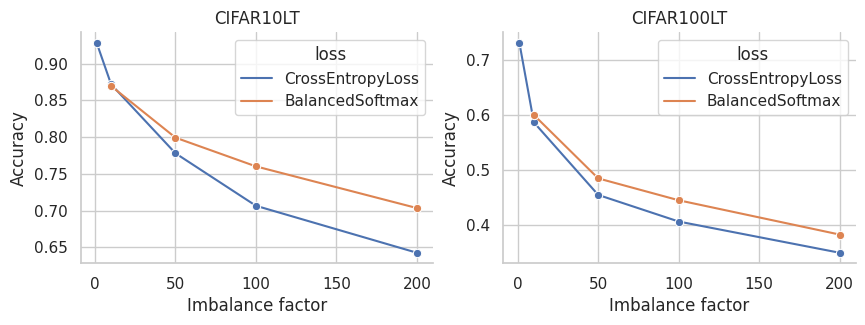

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
for i, d in enumerate(['CIFAR10LT', 'CIFAR100LT']):
    sns.lineplot(
        x      = 'imbalance factor',
        y      = 'acc',
        marker = 'o',
        hue    = 'loss',
        hue_order = ['CrossEntropyLoss','BalancedSoftmax'],
        data   = df[df['dataset'] == d],
        ax     = ax[i]
    )
    ax[i].set_ylabel('Accuracy')
    ax[i].set_xlabel('Imbalance factor')
    ax[i].set_title(d)
    
    plt.savefig(os.path.join(savedir, 'figure1.jpg'), dpi=300)

In [71]:
df = df.set_index(['dataset','imbalance factor','loss']).unstack().T
df.to_csv(os.path.join(savedir, 'table1.csv'))

In [72]:
df

dataset              CIFAR100LT                                 CIFAR10LT  \
imbalance factor            1       10      50      100     200       1     
    loss                                                                    
acc BalancedSoftmax         NaN  0.5999  0.4845  0.4447  0.3823       NaN   
    CrossEntropyLoss     0.7313  0.5865  0.4544  0.4060  0.3492    0.9283   

dataset                                               
imbalance factor         10      50      100     200  
    loss                                              
acc BalancedSoftmax   0.8694  0.7992  0.7601  0.7034  
    CrossEntropyLoss  0.8717  0.7779  0.7065  0.6426

# Comparison accuracy per class by imbalance factors

In [80]:
# get results per class
df_per_cls_cifar10lt = get_results_per_cls(dataname='CIFAR10LT', num_classes=10)
df_per_cls_cifar100lt = get_results_per_cls(dataname='CIFAR100LT', num_classes=100)
df_per_cls = pd.concat([df_per_cls_cifar10lt, df_per_cls_cifar100lt], axis=0)
df_per_cls = df_per_cls[df_per_cls['imbalance factor']!=1]

imb_factor = [10, 50, 100, 200]

# CIFAR10LT
num_per_cls_cifar10lt = []
for if_i in imb_factor:
    num_per_cls_cifar10lt.append(get_num_per_cls(datasize=50000, imb_factor=if_i, num_classes=10))

df_num_per_cls_cifar10lt = pd.DataFrame(
    num_per_cls_cifar10lt, 
    columns=range(10), 
)
df_num_per_cls_cifar10lt['imbalance factor'] = imb_factor
df_num_per_cls_cifar10lt['dataset'] = 'CIFAR10LT'

df_num_per_cls_cifar10lt = df_num_per_cls_cifar10lt.set_index(['imbalance factor','dataset']).stack().reset_index()
df_num_per_cls_cifar10lt.rename(
    columns={'level_2':'cls', 0:'nb_img'}, 
    inplace=True
)

    
# CIFAR100LT
num_per_cls_cifar100lt = []
for if_i in imb_factor:
    num_per_cls_cifar100lt.append(get_num_per_cls(datasize=50000, imb_factor=if_i, num_classes=100))

df_num_per_cls_cifar100lt = pd.DataFrame(
    num_per_cls_cifar100lt, 
    columns=range(100)
)

df_num_per_cls_cifar100lt['imbalance factor'] = imb_factor
df_num_per_cls_cifar100lt['dataset'] = 'CIFAR100LT'

df_num_per_cls_cifar100lt = df_num_per_cls_cifar100lt.set_index(['imbalance factor','dataset']).stack().reset_index()
df_num_per_cls_cifar100lt.rename(
    columns={'level_2':'cls', 0:'nb_img'}, 
    inplace=True
)

# concatenate CIFAR10LT and CIFAR100LT
df_num_per_cls = pd.concat([df_num_per_cls_cifar10lt, df_num_per_cls_cifar100lt], axis=0)

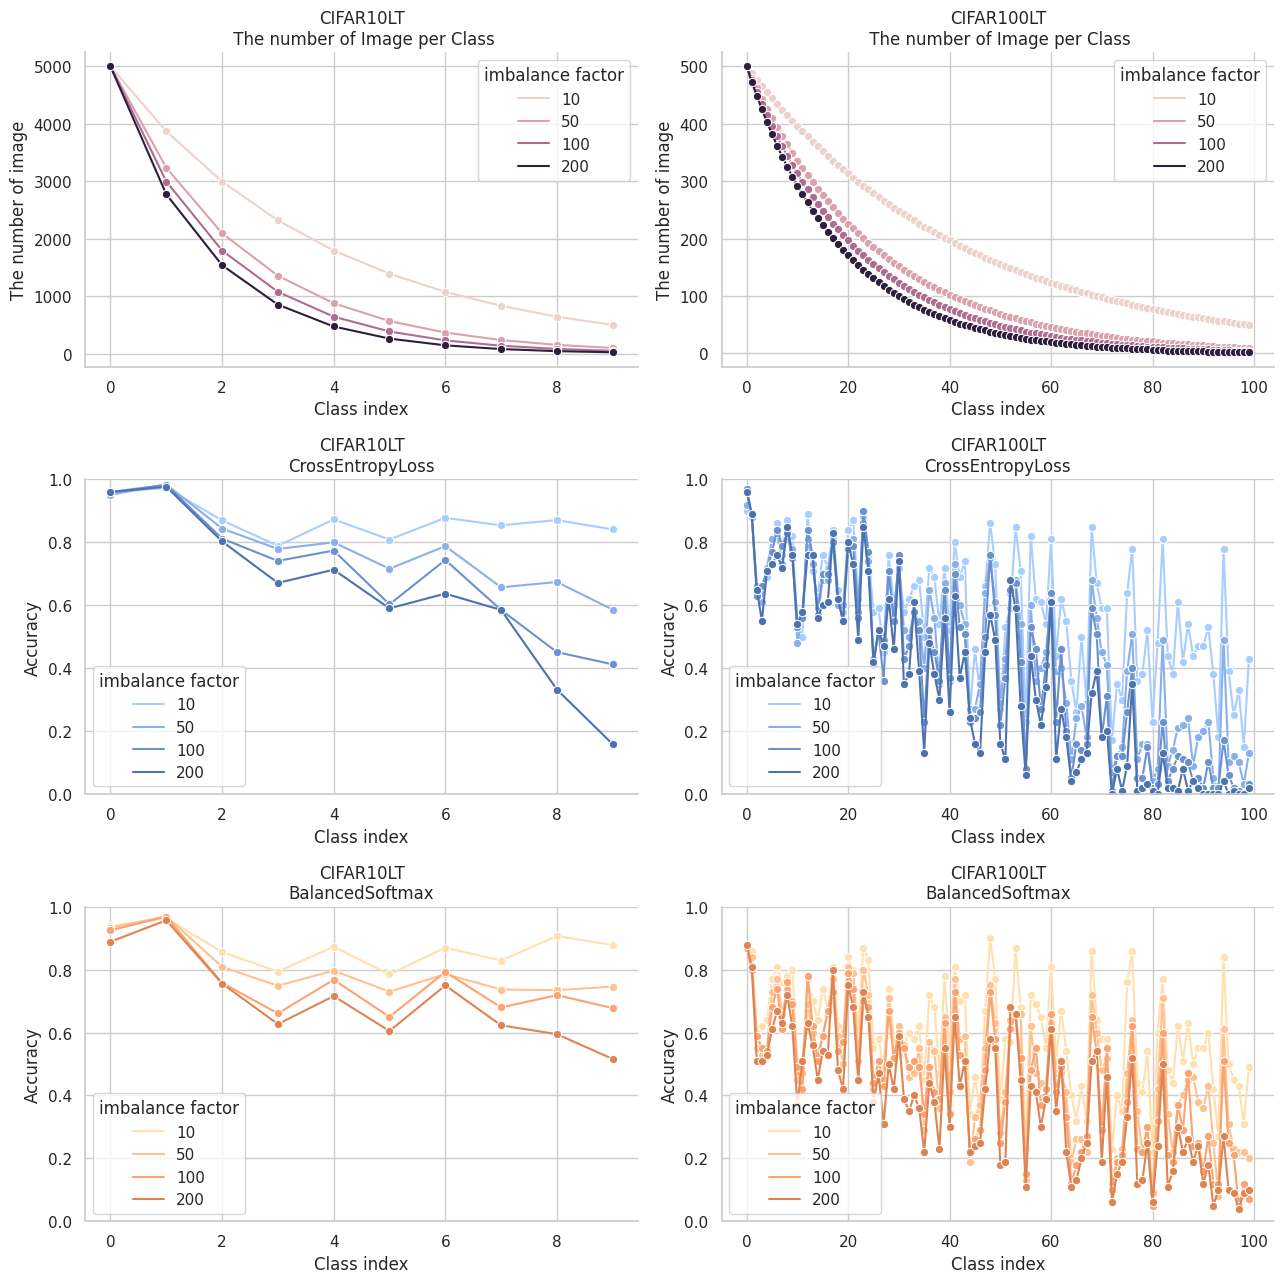

In [81]:
fig, ax = plt.subplots(3, 2, figsize=(13,13))

for c, d_name in enumerate(['CIFAR10LT', 'CIFAR100LT']):
    sns.lineplot(
        x    = 'cls',
        y    = 'nb_img',
        hue  = 'imbalance factor',
        marker = 'o',
        data = df_num_per_cls[df_num_per_cls['dataset']==d_name],
        ax   = ax[0, c]
    )
    ax[0, c].set_ylabel('The number of image')
    ax[0, c].set_xlabel('Class index')
    ax[0, c].set_title(f'{d_name}\n The number of Image per Class')

for c, d_name in enumerate(['CIFAR10LT', 'CIFAR100LT']):
    for r, l_name in enumerate(['CrossEntropyLoss', 'BalancedSoftmax']):
        sns.lineplot(
            x       = 'cls',
            y       = 'acc',
            hue     = 'imbalance factor',
            hue_order = imb_factor,
            marker  = 'o',
            palette = custom_palette(rgb=sns.color_palette()[r], n_colors=4),
            data    = df_per_cls[(df_per_cls['loss']==l_name) & (df_per_cls['dataset']==d_name)],
            ax      = ax[r+1, c]
        )
        ax[r+1, c].set_ylim([0,1])
        ax[r+1, c].set_ylabel('Accuracy')
        ax[r+1, c].set_xlabel('Class index')
        ax[r+1, c].set_title(f'{d_name}\n{l_name}')
        
plt.tight_layout()
plt.savefig(os.path.join(savedir, 'figure2.jpg'), dpi=300)
plt.show()

# Heatmap per class

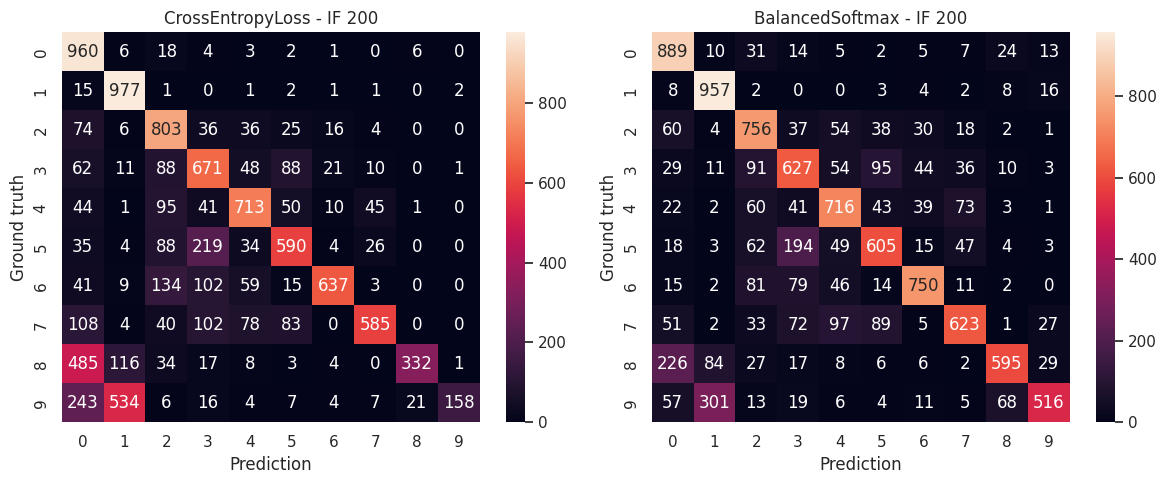

In [106]:
p_ce = f'./results/CIFAR10LT/resnet18/CrossEntropyLoss-IF_200/results-seed0-per_class.json'
p_bs = f'./results/CIFAR10LT/resnet18/BalancedSoftmax-IF_200/results-seed0-per_class.json'

heatmap_cifar10lt_if200_ce = json.load(open(p_ce, 'r'))['cm']
heatmap_cifar10lt_if200_bs = json.load(open(p_bs, 'r'))['cm']
heatmap_cifar10lt_if200 = [heatmap_cifar10lt_if200_ce, heatmap_cifar10lt_if200_bs]
titles = ['CrossEntropyLoss - IF 200', 'BalancedSoftmax - IF 200']

fig, ax = plt.subplots(1, len(heatmap_cifar10lt_if200), figsize=(12,5))

for i, h in enumerate(heatmap_cifar10lt_if200):
    sns.heatmap(h, annot=True, fmt='d', ax=ax[i])

    ax[i].set_ylabel('Ground truth')
    ax[i].set_xlabel('Prediction')
    ax[i].set_title(titles[i])
plt.tight_layout()
plt.savefig(os.path.join(savedir, 'figure3.jpg'), dpi=300)
plt.show()